# (시도) Eearthquake
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연, 최규빈

### imports

In [124]:
import tqdm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML

### load data and clean it

`-` load

In [4]:
df= pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')
df

,Date,Latitude,Longitude,Magnitude
0,01/02/1965,19.2460,145.6160,6.0
1,01/04/1965,1.8630,127.3520,5.8
2,01/05/1965,-20.5790,-173.9720,6.2
3,01/08/1965,-59.0760,-23.5570,5.8
4,01/09/1965,11.9380,126.4270,5.8
...,...,...,...,...
23407,12/28/2016,38.3917,-118.8941,5.6
23408,12/28/2016,38.3777,-118.8957,5.5
23409,12/28/2016,36.9179,140.4262,5.9
23410,12/29/2016,-9.0283,118.6639,6.3


`-` cleaning

In [5]:
df.Date[df.Date == '1975-02-23T02:58:41.000Z']

3378    1975-02-23T02:58:41.000Z
Name: Date, dtype: object

In [6]:
df.iloc[3378,0] = '02/03/1975'

In [7]:
df.Date[df.Date == '1985-04-28T02:53:41.530Z']

7512    1985-04-28T02:53:41.530Z
Name: Date, dtype: object

In [8]:
df.iloc[7512,0] = '04/28/1985'

In [9]:
df.Date[df.Date == '2011-03-13T02:23:34.520Z']

20650    2011-03-13T02:23:34.520Z
Name: Date, dtype: object

In [10]:
df.iloc[20650,0] = '03/13/2011'

In [11]:
df= df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).iloc[:,1:]
df

,Latitude,Longitude,Magnitude,Year
0,19.2460,145.6160,6.0,1965
1,1.8630,127.3520,5.8,1965
2,-20.5790,-173.9720,6.2,1965
3,-59.0760,-23.5570,5.8,1965
4,11.9380,126.4270,5.8,1965
...,...,...,...,...
23407,38.3917,-118.8941,5.6,2016
23408,38.3777,-118.8957,5.5,2016
23409,36.9179,140.4262,5.9,2016
23410,-9.0283,118.6639,6.3,2016


In [12]:
df.Year.unique()

array(['1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972',
       '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016'], dtype=object)

In [13]:
df.Year = df.Year.astype(np.float64)

### define class

In [179]:
class MooYaHo:
    def __init__(self,df):
        self.df = df 
        self.f = df.Magnitude.to_numpy()
        self.year = df.Year.to_numpy()
        self.lat = df.Latitude.to_numpy()
        self.long = df.Longitude.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.lat, self.long],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n): 
                self.D[i,j]=haversine(locations[i],locations[j])
        self.D = self.D+self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D<kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
#         nlst = self.df.groupby('Year').aggregate(len).Latitude.tolist()
#         nlst = [0]+np.cumsum(nlst).tolist()
#         beta_matrix = np.zeros([self.n,self.n])
#         for i in range(len(nlst)-1):
#             beta_matrix[nlst[i]:nlst[i+1],nlst[i]:nlst[i+1]] = beta
#         self.W = self.W * beta_matrix 
#     def _get_laplacian(self):
#         self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
#         self.lamb, self.Psi = np.linalg.eigh(self.L)
#         self.Lamb = np.diag(self.lamb)  

    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)        
    def fit(self,m):
        self._eigen()
        self.fhat = self.Psi[:,0:m]@self.Psi[:,0:m].T@self.f
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        plt.plot(self.f,'.')
        plt.plot(self.fhat,'x')
        
    def vis(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.3,
                        mapbox_style="stamen-terrain")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      marker_size= 8,
                      marker_color= 'red',
                      opacity = 1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 1
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

### analysis

`-` make instance for analysis

In [180]:
moo=MooYaHo(df.query("Year == 2005"))

- 테스트용으로 2016년 자료만 수집

`-` get distance 

In [181]:
moo.get_distance()

100%|██████████| 533/533 [00:00<00:00, 1508.36it/s]


In [182]:
moo.D[moo.D>0].mean()

8576.00324458316

- 0이 아닌 거리의 평균은 8600정도?

(array([30474., 27992., 39924., 38906., 39030., 32260., 27604., 17046.,
        19656., 10664.]),
 array([4.58452241e-01, 1.99911038e+03, 3.99776231e+03, 5.99641424e+03,
        7.99506617e+03, 9.99371810e+03, 1.19923700e+04, 1.39910220e+04,
        1.59896739e+04, 1.79883258e+04, 1.99869777e+04]),
 <BarContainer object of 10 artists>)

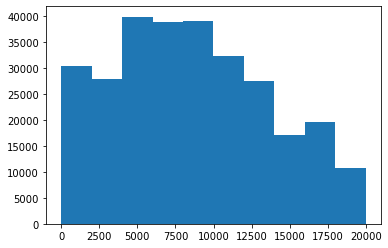

In [183]:
plt.hist(moo.D[moo.D>0])

- 히스토그램결과 -> 2500보다 거리가 작으면 거의 같은 지역이라고 봐도 무방할듯

`-` weight matrix

In [184]:
moo.get_weightmatrix(theta=(8647.92),kappa=2500) 

- 평균적으로 노드는 `np.exp(-(dist/8647)**2)=np.exp(-1)=0.36787944117144233` 정도의 연결강도를 가진다. 
- 거리가 2500이하이면 weight를 1로 설정한다. 

`-` fit

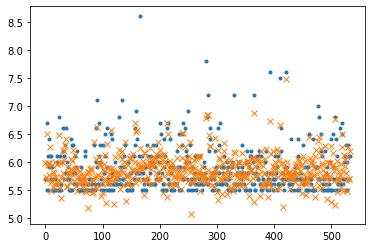

In [185]:
moo.fit(m=250)

`-` vis

In [188]:
#moo.vis(MagThresh=7,ResThresh=10) # <- 실행해봐요

- 전체자료는 underlying에 위치 
- 지진강도가 MagThresh 이상인 자료는 붉은점으로 시각화함 
- 이상치정도(우리가 제안하는 새로운 메져) ResThresh 이상인 자료는 파란점으로 시각화함 

### 한계점 (?)

`-` 시간효과를 따로 모형화하지는 않음 

---

In [143]:
pd.read_html('https://ko.wikipedia.org/wiki/%EC%A7%80%EC%A7%84_%EB%AA%A9%EB%A1%9D',encoding='utf-8')[0].iloc[[1,2,3],:] # 가장 피해가 컸던 지진

,순위,일자,장소,이름,사망자,규모,비고
1,2,1976년 7월 28일,중국 탕산,탕산지진,"255,000 (공식)",7.5,NaN
2,3,2010년 1월 12일,아이티,2010년 아이티 지진,"230,000 이상",7.0,NaN
3,4,2004년 12월 26일,인도네시아 수마트라섬,2004년 인도양 지진 해일,230210,9.1-9.3,NaN


In [146]:
pd.read_html('https://ko.wikipedia.org/wiki/%EC%A7%80%EC%A7%84_%EB%AA%A9%EB%A1%9D',encoding='utf-8')[1].iloc[[2,3,8],:]# 가장 규모가 컸던 지진

,순위,일자,장소,이름,규모
2,3,2004년 12월 26일,인도네시아 수마트라섬,2004년 인도양 지진 해일,9.1-9.2
3,4,2011년 3월 11일,일본 산리쿠 해역,2011년 도호쿠 지방 태평양 앞바다 지진,9.1
8,6 (공동),2010년 2월 27일,칠레 마울레주 해역,2010년 칠레 지진,8.8


In [147]:
pd.read_html('https://ko.wikipedia.org/wiki/2016%EB%85%84_%EC%A7%80%EC%A7%84#cite_note-1',encoding='utf-8')[2] # 2006년부터 2016년까지의 세계 지진 발생 수

,매그니튜드,2006년,2007년,2008년,2009년,2010년,2011년,2012년,2013년,2014년,2015년,2016년
0,8.0–9.9,2,4,0,1,1,1,2,2,1,1,0
1,7.0–7.9,9,14,12,16,23,19,14,17,11,18,16
2,6.0–6.9,142,178,167,144,151,187,117,123,143,127,130
3,5.0–5.9,1731,2090,1790,1920,2221,2486,1546,1454,1574,1412,1550
4,4.0–4.9,12861,12086,12306,6835,10140,13131,10957,11872,15816,13776,13699
5,합계,14746,14372,14277,8917,12539,15824,12637,13469,17545,15334,15395


https://www.usgs.gov/programs/earthquake-hazards/lists-maps-and-statistics

In [148]:
pd.read_html('https://www.usgs.gov/programs/earthquake-hazards/science/20-largest-earthquakes-world',encoding='utf-8')[1].iloc[[2,3,5,7,9,10,17,18],:] # A list of the 20 largest earthquakes in the world.

,No.,Mag,Location,Alternative Name,Date (UTC),Time (UTC),Latitude,Longitude,References
2,3.0,9.1,Off the West Coast of Northern Sumatra,"Sumatra-Andaman Islands Earthquake, 2004 Sumat...",2004-12-26,00:58,3.30°N,95.98°E,"Duputel et al., 2012"
3,4.0,9.1,"Near the East Coast of Honshu, Japan",Tohoku Earthquake,2011-03-11,05:46,38.30°N,142.37°E,"Duputel et al., 2012"
5,6.0,8.8,"Offshore Bio-Bio, Chile",Maule Earthquake,2010-02-27,06:34,36.12°S,72.90°W,"Duputel et al., 2012"
7,8.0,8.7,"Rat Islands, Aleutian Islands, Alaska",Rat Islands Earthquake,1965-02-04,05:01,51.25°N,178.72°E,"Kanamori & Anderson, 1975"
9,10.0,8.6,Off the West Coast of Northern Sumatra,NaN,2012-04-11,08:39,2.33°N,93.06°E,"Duputel et al., 2012"
10,11.0,8.6,"Northern Sumatra, Indonesia",Nias Earthquake,2005-03-28,16:10,2.09°N,97.11°E,NEIC
17,18.0,8.4,"Southern Sumatra, Indonesia",NaN,2007-09-12,11:10,4.44°S,101.37°E,NEIC
18,19.0,8.4,Near the Coast of Southern Peru,"Arequipa, Peru Earthquake",2001-06-23,20:33,16.27°S,73.64°W,"Duputel et al., 2012"


---

`-` 예상: 특정 진도 이상이면서 residual 1보다 큰 곳이 의미있는 지점일 것이다.
- 지진이 일어나지 않는 구간에서 지진이 일어났는데, 그것도 높은 진도로 일어났다는 뜻으로

`-` 1976년
- 중국 탕산 지진, 일어난 3곳 ( 2곳은 residual 1초과)

`-` 2004년
- 인도 수마트라섬 지진, 9 이상인 점(red)과 residual 1 초과인 점(blue)이 겹침
- 때때로 해구에 도달하는 지진에서 섭입판 경계면이 파열되어 1907년, 2004년, 2010년과 같은 대형 쓰나미가 발생한다. (https://ko.wikipedia.org/wiki/2022%EB%85%84_%EC%88%98%EB%A7%88%ED%8A%B8%EB%9D%BC_%EC%A7%80%EC%A7%84)

`-` 2010년
- 아이티지진(7.0)(지정한 MagThresh 기준은 초과이므로 6.9정도 넣고 돌림)
    - 진앙지가 한 곳뿐이라서 residual 계산이 안 되어 표시가 되지 않는 것으로 추측...
- 칠레 마줄레주해역 지진(8.8)

`-` 2011년
- 진도 9 이상 일본 한 건, 진도가 9이면서 residual이 1 초과인 1곳 존재

`-` 2016년
- 경주 지진 있던 해, 진도가 5.4 이상, 해당 데이터가 존재하지 않아 지도에도 표시되지 않음(한국의 지진 데이터가 없는 것 같다.)

https://levelup.gitconnected.com/plotting-usgs-earthquake-data-with-folium-8f11ddc21950

folium, plotly?